# Markov Decision Process (MDP)

### Ransalu Senanayake

In [1]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [2]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [3]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

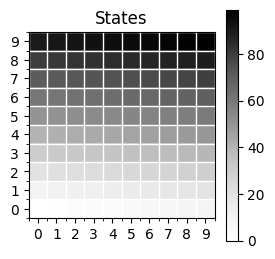

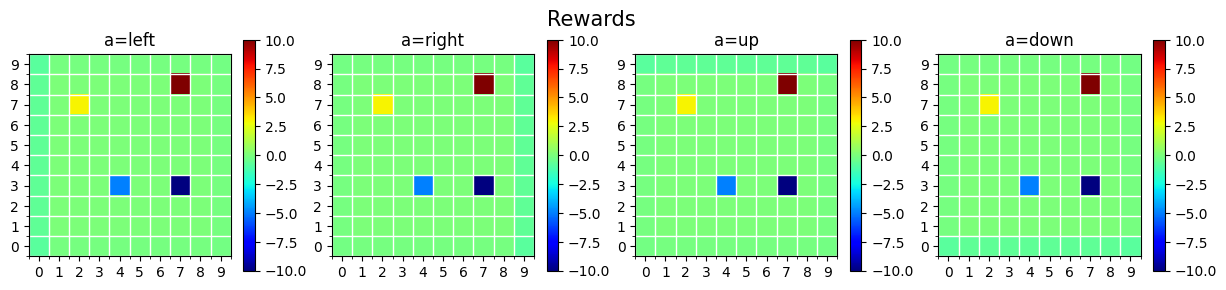

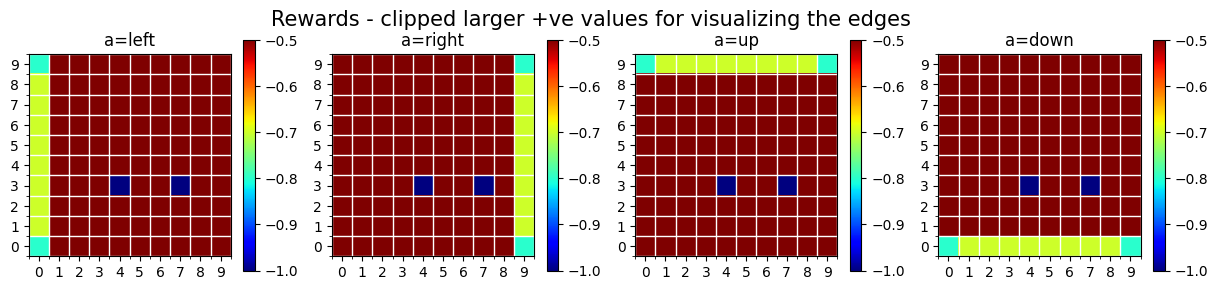

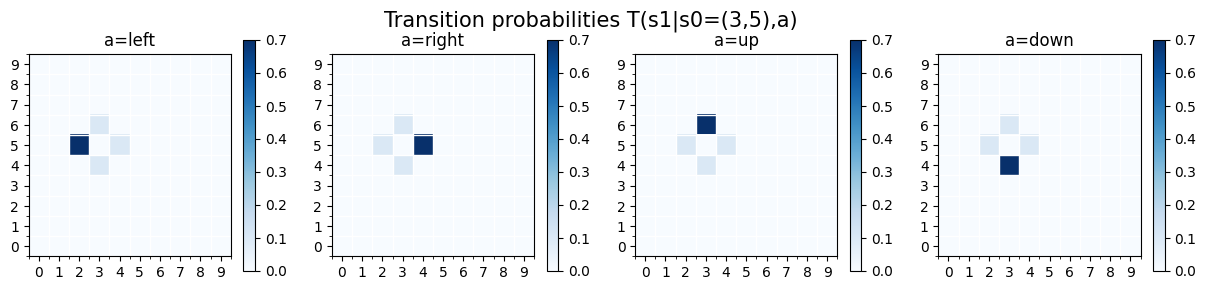

In [4]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [5]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

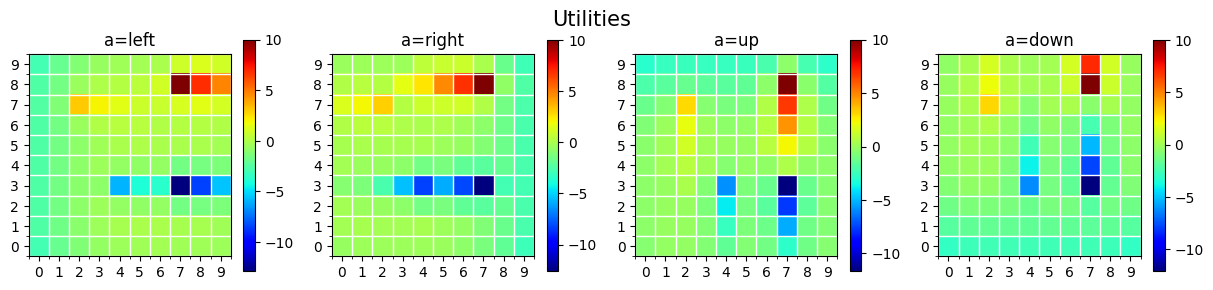

In [6]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      U_old = copy.copy(U)
      for s in mdp.S:
        a = policy if isinstance(policy, (int, np.integer)) else policy[s]
        r = mdp.R[s, a]
        U[s] = r + mdp.discount * np.dot(mdp.T[s, a], U_old)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [7]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

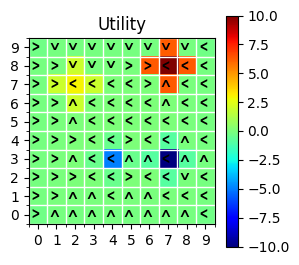

In [8]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      U_old = copy.copy(U)
      for s in mdp.S:
          U[s] = max([
              mdp.R[s, a_idx] + mdp.discount * np.dot(mdp.T[s, a_idx], U_old)
              for a_idx in range(len(mdp.A))
          ])
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    for s in mdp.S:
      q_vals = [
          mdp.R[s, a_idx] + mdp.discount * np.dot(mdp.T[s, a_idx], U)
          for a_idx in range(len(mdp.A))
      ]
      policy[s] = np.argmax(q_vals)
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

[Value Iteration] Sweeps: 61, Time: 0.0899s, Final Δ: 6.237e-07


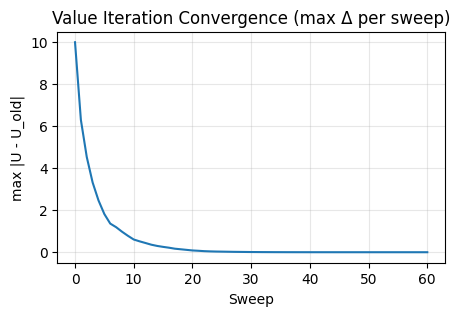

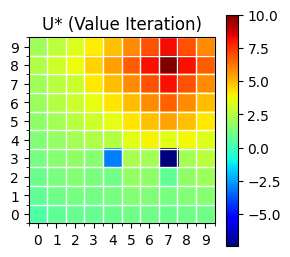

In [12]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

def run_value_iteration_with_tracking(mdp, max_iter=200, tol=1e-6):
  """
  Tracks convergence via max |U - U_old| at each sweep and total runtime.
  Uses array interface: mdp.R[s, a], mdp.T[s, a], mdp.discount, mdp.S, mdp.A
  """
  U = np.zeros(len(mdp.S), dtype=float)
  history = []
  start = timeit.default_timer()

  for t in range(max_iter):
    U_old = U.copy()
    for s in mdp.S:
      # Bellman optimality update
      U[s] = max([
          mdp.R[s, a_idx] + mdp.discount * np.dot(mdp.T[s, a_idx], U_old)
          for a_idx in range(len(mdp.A))
      ])
    delta = np.max(np.abs(U - U_old))
    history.append(delta)
    if delta < tol:
      break

  elapsed = timeit.default_timer() - start
  return U, np.array(history), elapsed

U_vi, vi_history, vi_time = run_value_iteration_with_tracking(mdp, max_iter=500, tol=1e-6)

print(f"[Value Iteration] Sweeps: {len(vi_history)}, Time: {vi_time:.4f}s, Final Δ: {vi_history[-1]:.3e}")

plt.figure(figsize=(5,3))
plt.plot(vi_history)
plt.title("Value Iteration Convergence (max Δ per sweep)")
plt.xlabel("Sweep")
plt.ylabel("max |U - U_old|")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(3,3))
mdp.gridPlot(ax=plt.gca(), im=U_vi.reshape(10,10), title='U* (Value Iteration)', cmap='jet')
plt.show()


In [9]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [19]:
def policyIteration(mdp, numIterations=1):
  U_pi_k = np.zeros(len(mdp.S)) #initial values
  pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
  pi_kp1 = copy.copy(pi_k)
  for t in range(numIterations):
    #Policy evaluation: compute U_pi_k
    U_old = copy.copy(U_pi_k)
    for s in mdp.S:
      a = pi_k[s]
      U_pi_k[s] = mdp.R[s, a] + mdp.discount * np.dot(mdp.T[s, a], U_old)

    #Policy improvement
    for s in mdp.S:
      q_vals = [
          mdp.R[s, a_idx] + mdp.discount * np.dot(mdp.T[s, a_idx], U_pi_k)
          for a_idx in range(len(mdp.A))
      ]
      pi_kp1[s] = int(np.argmax(q_vals))

    # use improved policy for next iteration
    pi_k = copy.copy(pi_kp1)

  return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)


[Policy Iteration] PI iters: 6, avg eval sweeps/iter: 47.17, Time: 0.1123s


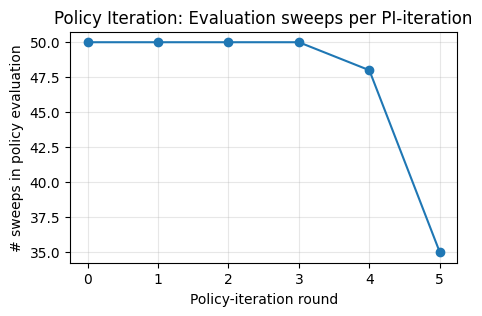

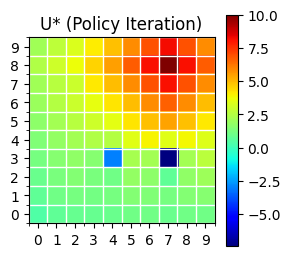

In [20]:
def run_policy_iteration_with_tracking(mdp, max_eval_sweeps=50, max_pi_iters=100, tol=1e-8):
  """
  Classic policy iteration with: (policy evaluation via iterative sweeps) + (policy improvement).
  Tracks: number of sweeps per evaluation and total runtime.
  """
  # init random policy over action indices
  pi = np.random.randint(low=0, high=len(mdp.A), size=len(mdp.S), dtype=int)
  U = np.zeros(len(mdp.S), dtype=float)

  eval_sweeps_each_round = []
  start = timeit.default_timer()

  for k in range(max_pi_iters):
    # Policy Evaluation (iterative, not solving linear system)
    sweeps = 0
    while sweeps < max_eval_sweeps:
      sweeps += 1
      U_old = U.copy()
      for s in mdp.S:
          a = pi[s]
          U[s] = mdp.R[s, a] + mdp.discount * np.dot(mdp.T[s, a], U_old)
      if np.max(np.abs(U - U_old)) < tol:
          break
    eval_sweeps_each_round.append(sweeps)

    # Policy Improvement
    stable = True
    for s in mdp.S:
      q_vals = [
          mdp.R[s, a_idx] + mdp.discount * np.dot(mdp.T[s, a_idx], U)
          for a_idx in range(len(mdp.A))
      ]
      best_a = int(np.argmax(q_vals))
      if best_a != pi[s]:
          stable = False
      pi[s] = best_a

    if stable:
      break

  elapsed = timeit.default_timer() - start
  return U, pi, np.array(eval_sweeps_each_round), elapsed

U_pi, pi_star, pi_eval_sweeps, pi_time = run_policy_iteration_with_tracking(mdp)

print(f"[Policy Iteration] PI iters: {len(pi_eval_sweeps)}, "
      f"avg eval sweeps/iter: {pi_eval_sweeps.mean():.2f}, Time: {pi_time:.4f}s")

plt.figure(figsize=(5,3))
plt.plot(pi_eval_sweeps, marker='o')
plt.title("Policy Iteration: Evaluation sweeps per PI-iteration")
plt.xlabel("Policy-iteration round")
plt.ylabel("# sweeps in policy evaluation")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(3,3))
mdp.gridPlot(ax=plt.gca(), im=U_pi.reshape(10,10), title='U* (Policy Iteration)', cmap='jet')
plt.show()


In [11]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

[Q-Learning] Episodes: 2000, Time: 30.2460s, Avg reward (last 100): 112.207


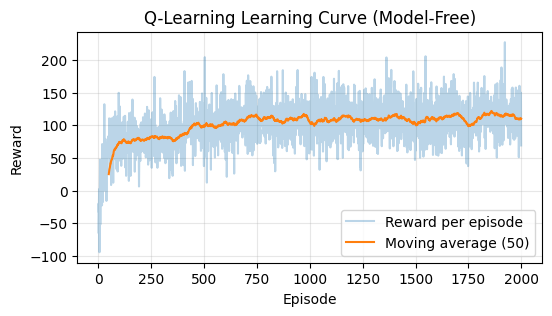

In [18]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

def _epsilon_greedy(Q, s, epsilon, nA):
  if np.random.rand() < epsilon:
    return np.random.randint(nA)
  q = Q[s]
  # break ties uniformly
  return int(np.random.choice(np.flatnonzero(q == q.max())))

def _sample_next_state(T_row, current_state=None):
  """
  Sample s' ~ T_row robustly.
  - Normalizes if sum != 1 due to FP drift.
  - Clips negatives to 0.
  - Falls back to staying in place (or random) if row is degenerate.
  """
  probs = np.asarray(T_row, dtype=float).copy()
  # Numerical hygiene
  probs[probs < 0.0] = 0.0
  total = probs.sum()

  # If badly formed or sum ~ 0, stay in place or pick random
  if not np.isfinite(total) or total <= 0.0:
    return int(current_state) if current_state is not None else int(np.random.randint(len(probs)))

  # Normalize with tolerance
  if abs(total - 1.0) > 1e-12:
    probs /= total

  # Final guard (rare): if rounding made last element tiny negative
  probs = np.clip(probs, 0.0, 1.0)
  probs /= probs.sum()

  return int(np.random.choice(len(probs), p=probs))


def q_learning_on_mdp(mdp, episodes=2000, max_steps=200, alpha=0.1, gamma=None, epsilon=0.1):
  if gamma is None:
    gamma = mdp.discount
  nS, nA = len(mdp.S), len(mdp.A)
  Q = np.zeros((nS, nA), dtype=float)
  rewards = []

  start = timeit.default_timer()
  for ep in range(episodes):
    # start from a random state each episode
    s = np.random.randint(nS)
    ep_reward = 0.0

    for _ in range(max_steps):
      a = _epsilon_greedy(Q, s, epsilon, nA)
      r = mdp.R[s, a]
      s_next = _sample_next_state(mdp.T[s, a])

      # Q-learning update
      Q[s, a] = (1 - alpha) * Q[s, a] + alpha * (r + gamma * Q[s_next].max())
      ep_reward += r
      s = s_next

    rewards.append(ep_reward)

  elapsed = timeit.default_timer() - start

  rewards = np.array(rewards, dtype=float)
  if len(rewards) >= 50:
    kernel = np.ones(50) / 50.0
    rewards_smooth = np.convolve(rewards, kernel, mode='valid')
    smooth_shift = 49
  else:
    rewards_smooth = rewards
    smooth_shift = 0

  return Q, rewards, rewards_smooth, smooth_shift, elapsed

# run Q-learning
Q, rewards, rewards_smooth, smooth_shift, q_time = q_learning_on_mdp(
    mdp, episodes=2000, max_steps=200, alpha=0.1, gamma=mdp.discount, epsilon=0.1
)

print(f"[Q-Learning] Episodes: {len(rewards)}, Time: {q_time:.4f}s, "
      f"Avg reward (last 100): {np.mean(rewards[-100:]):.3f}")

# learning curve
plt.figure(figsize=(6,3))
plt.plot(rewards, alpha=0.3, label='Reward per episode')
if len(rewards_smooth) > 1:
  plt.plot(np.arange(len(rewards_smooth)) + smooth_shift, rewards_smooth, label='Moving average (50)')
plt.title("Q-Learning Learning Curve (Model-Free)")
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

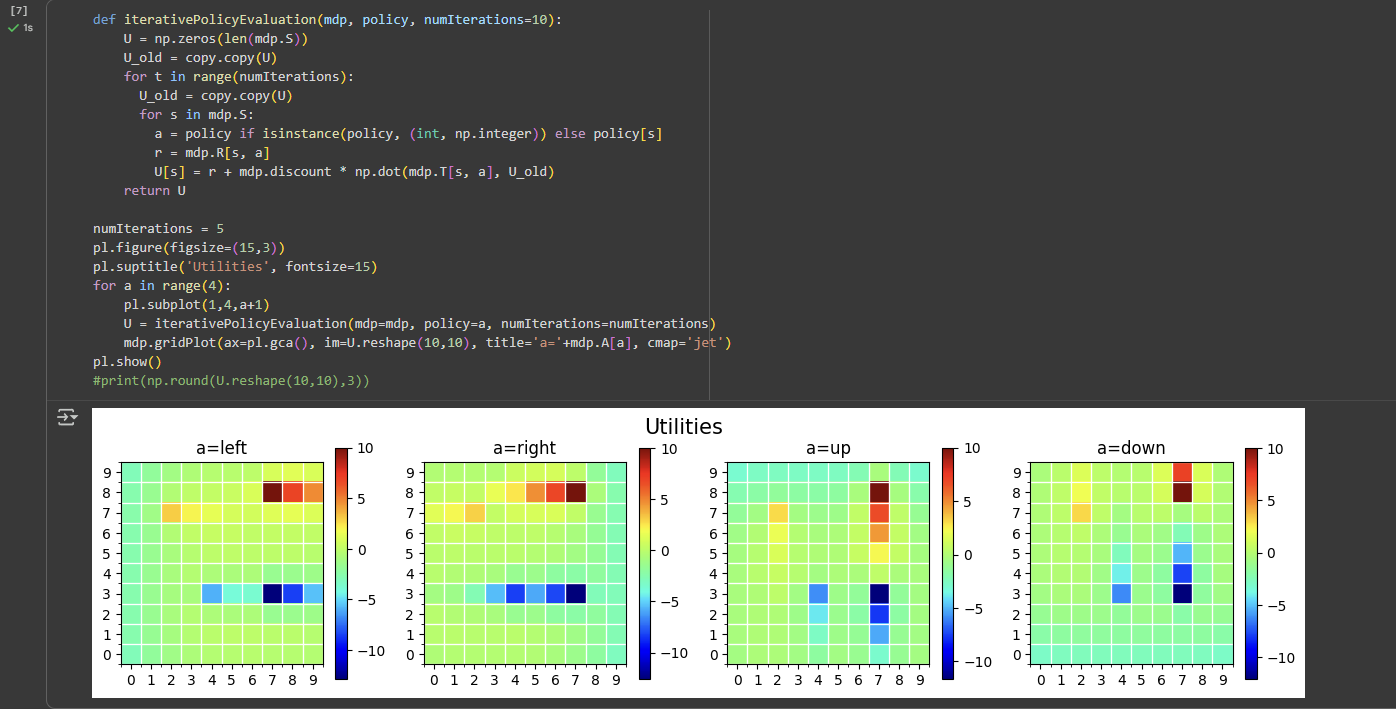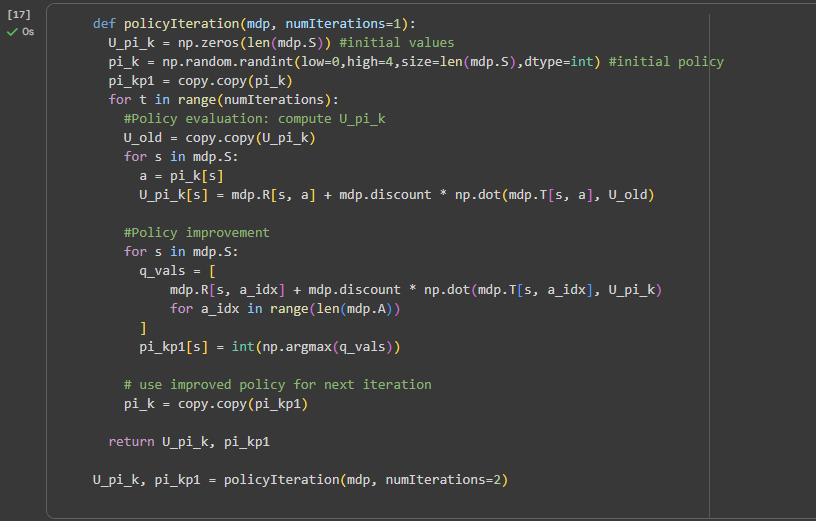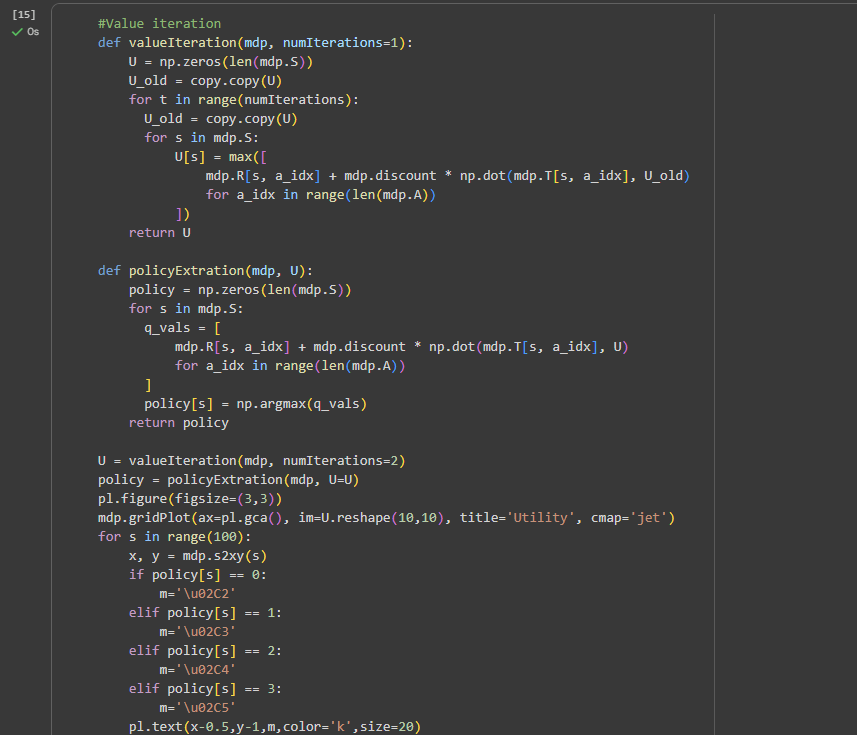

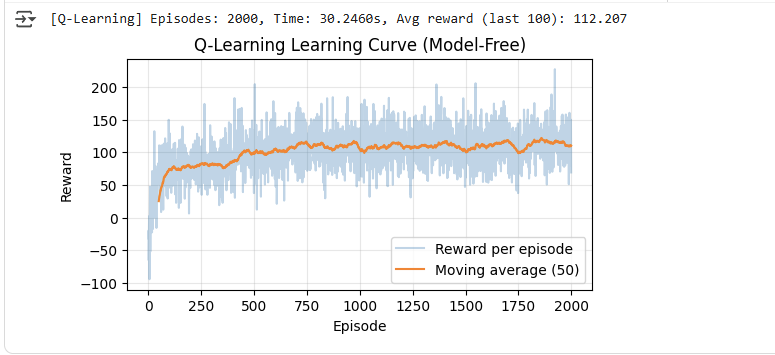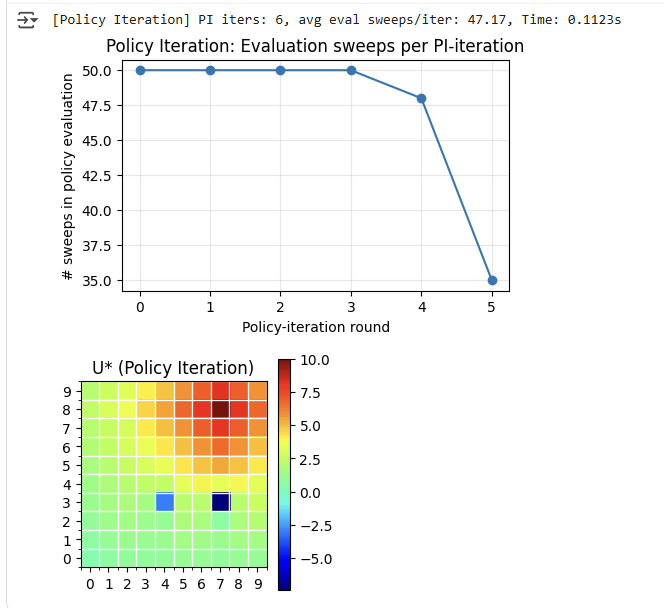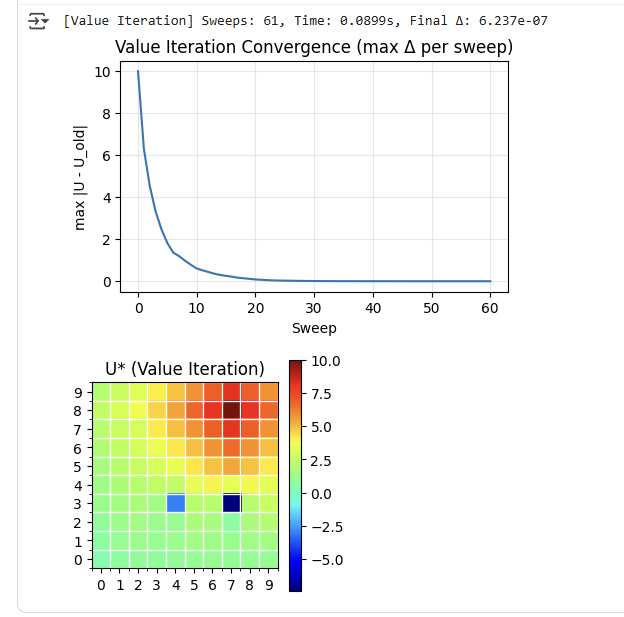